# Data Science with Python and Dask
##Summarizing and Analyzing DataFrame

In [ ]:
# Before beginning, set your working directory to where the data resides, Mount to google drive if you use Google
import os
os.chdir()

###Calculating descriptive statistic with Dask

In [ ]:
import dask.dataframe as dd
import pyarrow
from dask.diagnostics import ProgressBar

nyc_data = dd.read_parquet('nyc_final2', engine='pyarrow')

checking the vehicle year column for anomalies

Notice:  value counts shows some vehicles that were allegedly made in year 0 as well as long into the future

In [ ]:
with ProgressBar():
    vehicle_age_by_year = nyc_data['Vehicle Year'].value_counts().compute()
vehicle_age_by_year

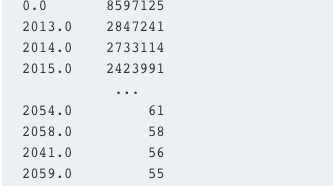

Filtering out bad data using boolean filtering

Create a filter expression that will remove rows where the vehicle year is less than 0 or greater than 2018 (since the dataset spans 2017)

Apply the boolean filter expression to the data, and count the number of vehicles by vehicle year

In [ ]:
with ProgressBar():
    condition = (nyc_data['Vehicle Year'] > 0) & (nyc_data['Vehicle Year'] <= 2018)
    vehicle_age_by_year = nyc_data[condition]['Vehicle Year'].value_counts().compute().sort_index()
vehicle_age_by_year

Calculate the vehicle age at the date of citation
- Apply the filter condition to the data.
- Define a function that will subtract the Vehicle Year column from the date column.
- Apply the calculation to each row, creating a derived column.
- Use the assign-rename pattern to add the new column to the original DataFrame.
- filter out any row where the vehicle age is negative.



In [ ]:
nyc_data_filtered = nyc_data[condition]

def age_calculation(row):
    return int(row['Issue Date'].year - row['Vehicle Year'])

vehicle_age = nyc_data_filtered.apply(age_calculation, axis=1, meta=('Vehicle Age', 'int'))

nyc_data_vehicle_age_stg1 = nyc_data_filtered.assign(VehicleAge=vehicle_age)
nyc_data_vehicle_age_stg2 = nyc_data_vehicle_age_stg1.rename(columns={'VehicleAge':'Vehicle Age'})

nyc_data_with_vehicle_age = nyc_data_vehicle_age_stg2[nyc_data_vehicle_age_stg2['Vehicle Age'] >= 0]

Calculate the mean could take a long time - summing all values in the column.

Use the persist method to hold the results of this expensive computation in memory. However, we will instead save the intermediate result as a Parquet file, because we will use this data again



In [ ]:
with ProgressBar():
    files = nyc_data_with_vehicle_age.to_parquet('nyc_data_vehicleAge', engine='pyarrow')

nyc_data_with_vehicle_age = dd.read_parquet('nyc_data_vehicleAge', engine='pyarrow')

Dask provides built-in descriptive statistics functions.

Compute the skewness by feeding the Vehicle Age column into the dask_stats.skew function, and cast the result to a float.

To calculate the skewness for this example, must convert Vehicle Age from a Dask Series object to a Dask Array object, since the skew function from dask.array requires a Dask Array as input.

In [ ]:
from dask.array import stats as dask_stats
with ProgressBar():
    mean = nyc_data_with_vehicle_age['Vehicle Age'].mean().compute()
    stdev = nyc_data_with_vehicle_age['Vehicle Age'].std().compute()
    minimum = nyc_data_with_vehicle_age['Vehicle Age'].min().compute()
    maximum = nyc_data_with_vehicle_age['Vehicle Age'].max().compute()
    skewness = float(dask_stats.skew(nyc_data_with_vehicle_age['Vehicle Age'].values).compute())

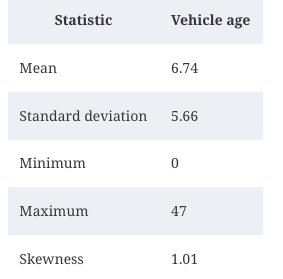

Results:
- Ticketed vehicles, on average, are about seven years old.
- There are some brand-new vehicles (denoted by a minimum age of 0 years), and the oldest vehicle was 47 years old.
- The standard deviation of 5.66 indicates that, on average, vehicles in this dataset tend to be +/– 5.66 years from the average age of 6.74 years.
- The data has a positive skew, meaning vehicles that were newer that 6.74 years were more common than vehicles that were older than 6.74 years.

###Using the describe method for descriptive statistics

Dask also gives you another shortcut for calculating descriptive statistics.

Round the descriptive stats to 2 decimal places.

In [ ]:
with ProgressBar():
    descriptive_stats = nyc_data_with_vehicle_age['Vehicle Age'].describe().compute()
descriptive_stats.round(2)

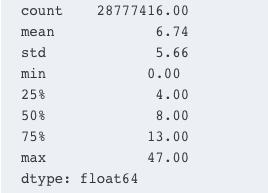

##Built-in Aggregate functions

Patterns and relationships in data, we’re usually talking more specifically about the correlation of two variables
- postive
- no correlation
- negative


###Calculating correlations with Dask DataFrames


QUESTIONS:
- Using the NYC Parking Ticket data, how many parking citations were issued each month?
- Does the average temperature correlate with the number of citations issued?



Create lists of all months and the years we want to investigate.

Map the month/year strings to sequential integers, which will be used to sort

Create a function that takes a DataFrame as input, and returns a sorted DataFrame as output.

In [ ]:
import pandas as pd

years = ['2014', '2015', '2016', '2017']
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
years_months = [year + month for year in years for month in months]

sort_order = pd.Series(range(len(years_months)), index=years_months, name='custom_sort')

def sort_by_months(dataframe, order):
    return dataframe.join(order).sort_values('custom_sort').drop('custom_sort', axis=1)

**GroupBy**

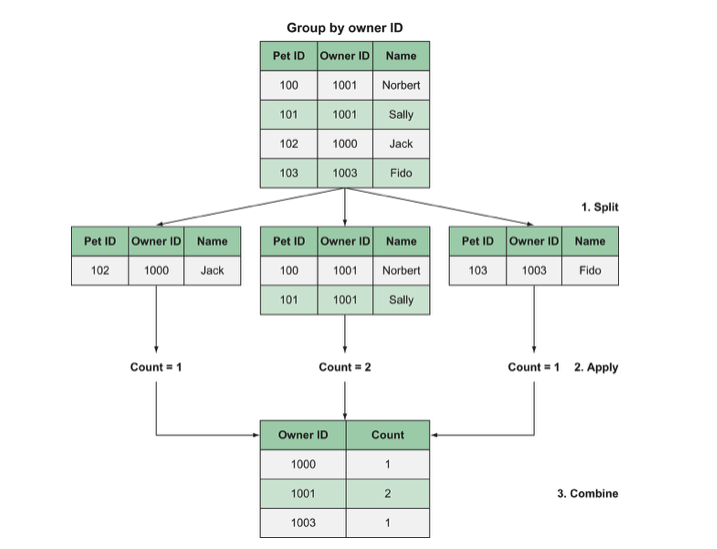

If we wanted to count the number of pets owned by each owner, we would group by the Owner ID and apply the count function to each group.

Under the hood -  original table is split into partitions, where each partition contains only pets owned by a single owner.

The original table is split into three partitions.

Next, we apply the aggregate function to each partition. Count will simply find how many rows are in each partition.

Left with a count of 1 for the left partition, a count of 2 for the center partition, and a count of 1 for the right partition. To reassemble the result, we’ll need to combine the results from each partition.

**Counting citations by month and year**
- Group by the monthYear column (notice the partition is index by month-year column. Less Shuffle and more efficient
- Count the number of citations in each group.
- Apply the custom sorting function to the result.


In [ ]:
with ProgressBar():
    nyc_data_by_month = nyc_data.groupby('monthYear')
    citations_per_month = nyc_data_by_month['Summons Number'].count().compute()
sort_by_months(citations_per_month.to_frame(), sort_order)

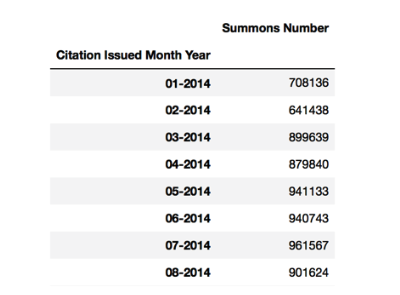

**Calculating the correlations between citations and temperature**

- create a filter express that only keeps data not in the last months of 2017 (by examining the output, citations count for last months of 2017 is very low (dataset is not complete)
- apply the filter
- group by citations issues month year colunmn, count the number of citations in each group, calculate average temperature in each group

In [ ]:
with ProgressBar():
    condition = ~nyc_data['monthYear'].isin(['201707','201708','201709','201710','201711','201712'])
    nyc_data_filtered = nyc_data[condition]
    citations_and_temps = nyc_data_filtered.groupby('monthYear').agg({'Summons Number': 'count', 'Temp': 'mean'})
    correlation_matrix = citations_and_temps.corr().compute()
correlation_matrix

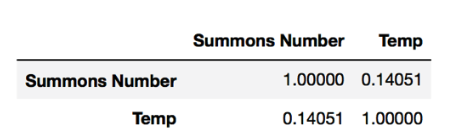

###Custom Aggregate functions

Not covered in this course

In [ ]:
# Listing 6.11
nyc_data_with_vehicle_age = dd.read_parquet('nyc_data_vehicleAge', engine='pyarrow')

nyc_data_filtered = nyc_data_with_vehicle_age[nyc_data_with_vehicle_age ['Plate Type'].isin(['PAS','COM'])]

In [ ]:
# Listing 6.12
with ProgressBar():
    N = nyc_data_filtered['Vehicle Age'].count().compute()
    p = nyc_data_filtered['Plate Type'].unique().count().compute()
brown_forsythe_left = (N - p) / (p - 1)

In [ ]:
# Listing 6.13
with ProgressBar():
    passenger_vehicles = nyc_data_filtered[nyc_data_filtered['Plate Type'] == 'PAS']
    commercial_vehicles = nyc_data_filtered[nyc_data_filtered['Plate Type'] == 'COM']
    median_PAS = passenger_vehicles['Vehicle Age'].quantile(0.5).compute()
    median_COM = commercial_vehicles['Vehicle Age'].quantile(0.5).compute()

In [ ]:
# Listing 6.14
def absolute_deviation_from_median(row):
    if row['Plate Type'] == 'PAS':
        return abs(row['Vehicle Age'] - median_PAS)
    else:
        return abs(row['Vehicle Age'] - median_COM)

In [ ]:
# Listing 6.15
absolute_deviation = nyc_data_filtered.apply(absolute_deviation_from_median, axis=1, meta=('x', 'float32'))

nyc_data_age_type_test_stg1 = nyc_data_filtered.assign(MedianDifferences = absolute_deviation)
nyc_data_age_type_test = nyc_data_age_type_test_stg1.rename(columns={'MedianDifferences':'Median Difference'})

In [ ]:
# Listing 6.16
with ProgressBar():
    group_means = nyc_data_age_type_test.groupby('Plate Type')['Median Difference'].mean().compute()

In [ ]:
# Listing 6.17
def group_mean_variance(row):
    if row['Plate Type'] == 'PAS':
        return (row['Median Difference'] - group_means['PAS'])**2
    else:
        return (row['Median Difference'] - group_means['COM'])**2

group_mean_variances = nyc_data_age_type_test.apply(group_mean_variance, axis=1, meta=('x', 'float32'))

nyc_data_age_type_test_gmv_stg1 = nyc_data_age_type_test.assign(GroupMeanVariances = group_mean_variances)
nyc_data_age_type_test_gmv = nyc_data_age_type_test_gmv_stg1.rename(columns={'GroupMeanVariances':'Group Mean Variance'})

In [ ]:
# Listing 6.18
with ProgressBar():
    brown_forsythe_right_denominator = nyc_data_age_type_test_gmv['Group Mean Variance'].sum().compute()

In [ ]:
# Listing 6.19
with ProgressBar():
    grand_mean = nyc_data_age_type_test['Median Difference'].mean().compute()

In [ ]:
# Listing 6.20
brown_forsythe_aggregation = dd.Aggregation(
    'Brown_Forsythe',
    lambda chunk: (chunk.count(), chunk.sum()),
    lambda chunk_count, chunk_sum: (chunk_count.sum(), chunk_sum.sum()),
    lambda group_count, group_sum: group_count * (((group_sum / group_count) - grand_mean)**2)
)

In [ ]:
# Listing 6.21
with ProgressBar():
    group_variances = nyc_data_age_type_test.groupby('Plate Type').agg({'Median Difference': brown_forsythe_aggregation}).compute()

In [ ]:
# Listing 6.22
brown_forsythe_right_numerator = group_variances.sum()[0]

In [ ]:
# Listing 6.23
F_statistic = brown_forsythe_left * (brown_forsythe_right_numerator / brown_forsythe_right_denominator)

In [ ]:
# Listing 6.24
import scipy.stats as stats
alpha = 0.05
df1 = p - 1
df2 = N - p
F_critical = stats.f.ppf(q=1-alpha, dfn=df1, dfd=df2)

In [ ]:
# Listing 6.25
print("Using the Brown-Forsythe Test for Equal Variance")
print("The Null Hypothesis states: the variance is constant among groups")
print("The Alternative Hypothesis states: the variance is not constant among groups")
print("At a confidence level of " + str(alpha) + ", the F statistic was " + str(F_statistic) + " and the F critical value was " + str(F_critical) + ".")
if F_statistic > F_critical:
    print("We can reject the null hypothesis. Set equal_var to False.")
else:
    print("We fail to reject the null hypothesis. Set equal_var to True.")

In [ ]:
# Listing 6.26
with ProgressBar():
    pas = passenger_vehicles['Vehicle Age'].values.compute()
    com = commercial_vehicles['Vehicle Age'].values.compute()

In [ ]:
# Listing 6.27
stats.ttest_ind(pas, com, equal_var=False)

###Rolling (window) functions

Concept of Windowing

A common application of windowing is analyzing data that has a time dimension, such as days or hours. For example, if we were analyzing sales revenue for an online store, we may want to know how many more (or fewer) items were sold today compared with yesterday, such as salest(t) – salest(t-1). It has a two-period window.

A 50-day simple moving average, which is commonly computed for describing the volatility and momentum of a publicly traded financial asset, is a good example of a more complicated window function with a larger window.

Due to the distributed nature of Dask, Dask has some limitations around the size of the window that you can use: the size of the window can’t be large enough to span more than one adjacent partition. e.g. If the paritiion is by month, the window size cannot be greater than 2 months. Otherwise, there will be a lot of shuffling.

you should ensure that the partition sizes you choose are large enough to avoid this boundary issue, but keep in mind that larger partitions can begin to slow down your computations.

The data should also be index-aligned to ensure that it’s sorted in the correct order.

###Preparing data for a rolling function


Look at a moving average of citations issued per month. What we’re aiming to find out is if we can spot any discernable trend in the data after smoothing out some of the volatility.


By averaging each month with a certain number of prior months, individual dips and spikes in a given month will be less prominent.

citation_by_month object representing a count of citations per month

In [ ]:
with ProgressBar():
    condition = ~nyc_data['monthYear'].isin(['201707','201708','201709','201710','201711','201712'])
    nyc_data_filtered = nyc_data[condition]
    citations_by_month = nyc_data_filtered.groupby(nyc_data_filtered.index)['Summons Number'].count()

### Rolling Method

Rolling method to tell Dask that we want to compute means in a three-period rolling window. Since the periods in this example are months, Dask will average together three-month rolling windows of monthly citation counts.

For the month of March 2017, Dask will compute the mean of the counts for March 2017, February 2017, and January 2017.

setting the center parameter of the rolling method means for the month of March 2017, Dask will compute the mean of the counts for Feb 2017, March 2017, and April 2017. i.e. one month before and one month after.

In [ ]:
with ProgressBar():
    three_month_SMA = citations_by_month.rolling(3).mean().compute()

In [ ]:
citations_by_month.rolling(3, center=True).mean().head()